In [1]:
import numpy as np
import pandas as pd
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


In [2]:
import nltk
nltk.download("popular")
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [3]:
df = pd.read_csv('https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))

                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs


In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['post'] = df['post'].apply(clean_text)

In [5]:
print(df.head(10))

                                                post           tags
0  causing behavior c# datetime type test public ...             c#
1  dynamic html load iframe aspnet 40 site users ...        asp.net
2  convert float value minsec trying convert seco...    objective-c
3  net framework 4 redistributable wondering get ...           .net
4  trying calculate print mean returning rather n...         python
5  give alias name website deployed aspnet site o...        asp.net
6  windowopen returns null angularjs works simple...      angularjs
7  identifying server timeout quickly iphone conn...         iphone
8  unknown method key error rails 238 unit testin...  ruby-on-rails
9  include show hide content according requiremen...      angularjs


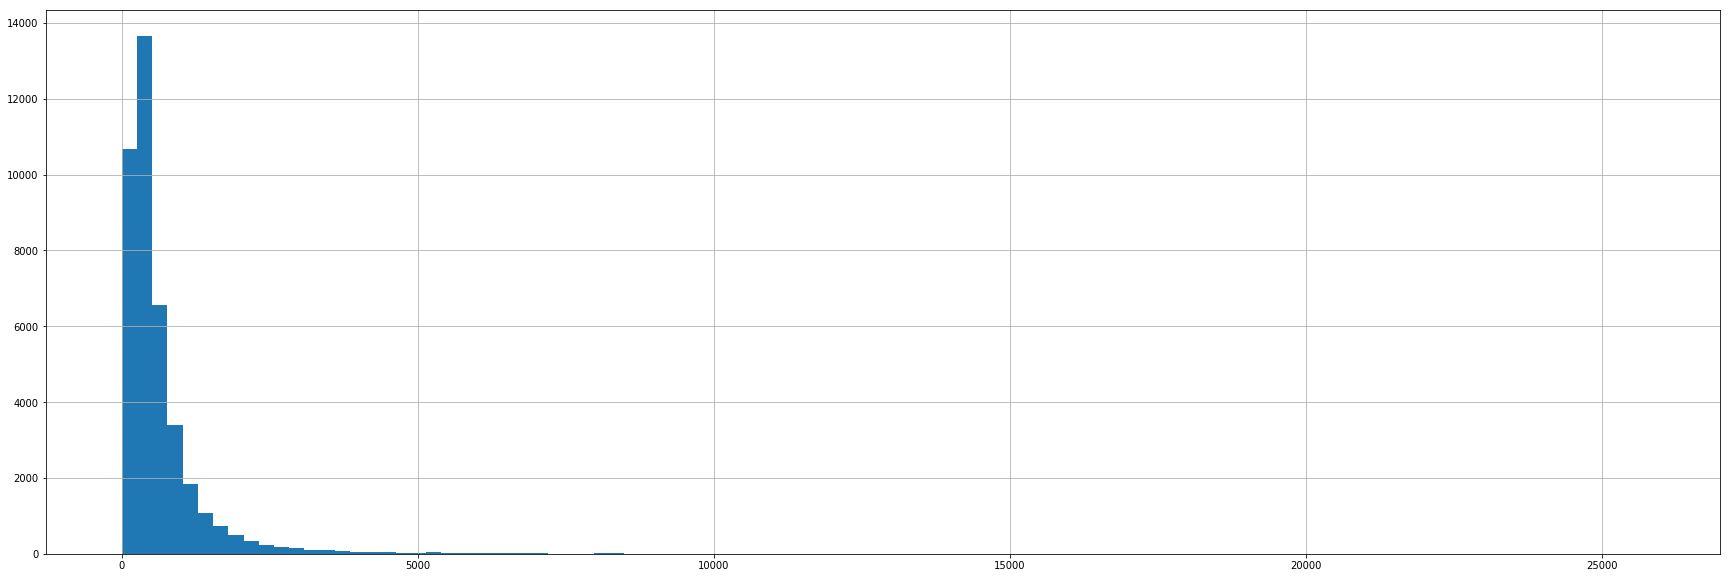

In [6]:
df['post_len'] = df.post.apply(len)
df.post_len.hist(bins=100,figsize=(30,10))


In [7]:
df = df.drop(['post_len'],axis=1)
df = pd.get_dummies(df, columns=["tags"])
print(df.head(10))

                                                post  tags_.net  tags_android  \
0  causing behavior c# datetime type test public ...          0             0   
1  dynamic html load iframe aspnet 40 site users ...          0             0   
2  convert float value minsec trying convert seco...          0             0   
3  net framework 4 redistributable wondering get ...          1             0   
4  trying calculate print mean returning rather n...          0             0   
5  give alias name website deployed aspnet site o...          0             0   
6  windowopen returns null angularjs works simple...          0             0   
7  identifying server timeout quickly iphone conn...          0             0   
8  unknown method key error rails 238 unit testin...          0             0   
9  include show hide content according requiremen...          0             0   

   tags_angularjs  tags_asp.net  tags_c  tags_c#  tags_c++  tags_css  \
0               0             0     

In [0]:
df_train, df_test = train_test_split(df, test_size=0.2)

train_texts = df_train.post.values
test_texts = df_test.post.values

In [9]:
#train_texts = [s.lower() for s in train_texts]
#test_texts = [s.lower() for s in test_texts]
print(len(df_train), len(df_test), len(train_texts), len(test_texts))

32000 8000 32000 8000


In [0]:
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token=' ')
tk.fit_on_texts(train_texts)

In [0]:
# construct a new vocabulary
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1

# Use char_dict to replace the tk.word_index
tk.word_index = char_dict.copy()
# Add 'UNK' to the vocabulary
tk.word_index[tk.oov_token] = max(char_dict.values()) + 1

In [0]:
# Convert string to index
train_sequences = tk.texts_to_sequences(train_texts)
test_sequences = tk.texts_to_sequences(test_texts)

In [13]:
for i in range(5):
    print(train_sequences[i])
    print(train_texts[i])
    print(len(train_texts[i]))

[16, 25, 20, 8, 15, 14, 69, 6, 9, 12, 5, 19, 69, 18, 21, 14, 69, 6, 9, 14, 5, 69, 5, 24, 5, 3, 21, 20, 5, 4, 69, 4, 9, 6, 6, 5, 18, 5, 14, 20, 69, 4, 9, 18, 5, 3, 20, 15, 18, 25, 69, 23, 9, 5, 18, 4, 69, 16, 18, 15, 2, 12, 5, 13, 69, 18, 21, 14, 69, 6, 9, 12, 5, 69, 4, 9, 6, 6, 5, 18, 5, 14, 20, 69, 4, 9, 18, 5, 3, 20, 15, 18, 25, 69, 18, 21, 14, 19, 69, 6, 9, 14, 5, 69, 23, 9, 19, 5, 69, 7, 5, 20, 69, 5, 18, 18, 15, 18, 69, 20, 5, 24, 20, 16, 18, 15, 3, 5, 19, 19, 15, 18, 69, 9, 13, 16, 15, 18, 20, 69, 6, 9, 12, 5, 69, 8, 15, 13, 5, 69, 13, 15, 8, 9, 20, 69, 4, 15, 3, 21, 13, 5, 14, 20, 19, 69, 1, 14, 1, 12, 25, 19, 9, 19, 69, 3, 1, 20, 5, 7, 15, 18, 9, 26, 1, 20, 9, 15, 14, 69, 20, 5, 24, 20, 16, 18, 15, 3, 5, 19, 19, 15, 18, 16, 25, 69, 12, 9, 14, 5, 69, 29, 69, 13, 15, 4, 21, 12, 5, 69, 9, 13, 16, 15, 18, 20, 69, 14, 12, 20, 11, 69, 6, 9, 12, 5, 69, 21, 19, 18, 69, 12, 15, 3, 1, 12, 69, 12, 9, 2, 69, 16, 25, 20, 8, 15, 14, 29, 34, 69, 4, 9, 19, 20, 16, 1, 3, 11, 1, 7, 5, 19, 69, 14

In [0]:
# Padding
# Because text have different length, we have to make all text as the same length, so the CNN can handle the batch data.
padding_size = 3000
train_data = pad_sequences(train_sequences, maxlen=padding_size, padding='post')
test_data = pad_sequences(test_sequences, maxlen=padding_size, padding='post')

In [15]:
train_data = np.array(train_data, dtype='float32')
test_data = np.array(test_data, dtype='float32')

print(train_data[0])
print(train_data.shape, test_data.shape)

[16. 25. 20. ...  0.  0.  0.]
(32000, 3000) (8000, 3000)


In [16]:
# Get Classes
classes_cols = df_train.drop(['post'],axis=1).columns

print(classes_cols)
train_classes = df_train[classes_cols].values
test_classes  = df_test[classes_cols].values

Index(['tags_.net', 'tags_android', 'tags_angularjs', 'tags_asp.net', 'tags_c',
       'tags_c#', 'tags_c++', 'tags_css', 'tags_html', 'tags_ios',
       'tags_iphone', 'tags_java', 'tags_javascript', 'tags_jquery',
       'tags_mysql', 'tags_objective-c', 'tags_php', 'tags_python',
       'tags_ruby-on-rails', 'tags_sql'],
      dtype='object')


In [0]:
# Shuffle
indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)

x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes

In [18]:
print(len(x_train),len(y_train),len(x_test),len(y_test))
print(x_train[:5])
print(y_train[:5])

32000 32000 8000 8000
[[ 3. 15. 21. ...  0.  0.  0.]
 [ 5. 24. 20. ...  0.  0.  0.]
 [ 3. 58. 58. ...  0.  0.  0.]
 [20.  5. 12. ...  0.  0.  0.]
 [14.  5. 20. ...  0.  0.  0.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [0]:
input_size = padding_size
vocab_size = len(tk.word_index)
embedding_size = 69
conv_layers = [[256, 7, 3],
               [256, 7, 3],
               #[256, 3, -1],
               [256, 3, -1],
               [256, 3, -1],
               [256, 3, 3]]

fully_connected_layers = [1024, 1024]
fully_connected_layers = [200, 100]
num_of_classes = len(classes_cols)
dropout_p = 0.2
optimizer = 'adam'     #!!! tf.keras.optimizers.Adam(lr=1e-3)
loss = 'categorical_crossentropy'

In [20]:
# Embedding weights
embedding_weights = []  # (70, 69) 
embedding_weights.append(np.zeros(vocab_size))  # (0, 69)

for char, i in tk.word_index.items():  # from index 1 to 69
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
print(embedding_weights.shape)

(70, 69)


In [0]:
# Embedding layer Initialization
embedding_layer = Embedding(vocab_size + 1,
                            embedding_size,
                            input_length=input_size,
weights=[embedding_weights])

In [22]:
# Model Construction

# Input
inputs = Input(shape=(input_size,), name='input', dtype='int64')  # shape=(?, 1014)

# Embedding
x = embedding_layer(inputs)

# Conv
for filter_num, filter_size, pooling_size in conv_layers:
    print('conv_layers ',filter_num, filter_size, pooling_size)
    x = Conv1D(filter_num, filter_size)(x)
    x = Activation('relu')(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)  # Final shape=(None, 34, 256)
    print(x.shape)
x = Flatten()(x)  # (None, 8704)

# Fully connected layers
for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='relu')(x)  # dense_size == 1024
    x = Dropout(dropout_p)(x)

# Output Layer
predictions = Dense(num_of_classes, activation='softmax')(x)

# Build model
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  # Adam, categorical_crossentropy
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
conv_layers  256 7 3
(?, 998, 256)
conv_layers  256 7 3
(?, 330, 256)
conv_layers  256 3 -1
(?, 328, 256)
conv_layers  256 3 -1
(?, 326, 256)
conv_layers  256 3 3
(?, 108, 256)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3000, 69)          4830      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2994, 256)         123904    
_________________________________________________________________
activation_1 (Activation)    (None, 2994, 256)         0         
__________________________________________

In [23]:
# Training
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=512,
          epochs=5,
          verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
 - 72s - loss: 2.9780 - acc: 0.0666 - val_loss: 2.9419 - val_acc: 0.0787
Epoch 2/5
 - 60s - loss: 2.7964 - acc: 0.0979 - val_loss: 2.5653 - val_acc: 0.1329
Epoch 3/5
 - 59s - loss: 2.4860 - acc: 0.1636 - val_loss: 2.2942 - val_acc: 0.2456
Epoch 4/5
 - 59s - loss: 2.1980 - acc: 0.2609 - val_loss: 2.0004 - val_acc: 0.3389
Epoch 5/5
 - 59s - loss: 1.8380 - acc: 0.3845 - val_loss: 1.6183 - val_acc: 0.4741


In [24]:
# Training
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=512,
          epochs=5,
          verbose=2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
 - 59s - loss: 1.4813 - acc: 0.5059 - val_loss: 1.2825 - val_acc: 0.5911
Epoch 2/5
 - 60s - loss: 1.1188 - acc: 0.6293 - val_loss: 1.0653 - val_acc: 0.6592
Epoch 3/5
 - 59s - loss: 0.9056 - acc: 0.6995 - val_loss: 1.0015 - val_acc: 0.6850
Epoch 4/5
 - 59s - loss: 0.7293 - acc: 0.7495 - val_loss: 1.0304 - val_acc: 0.6954
Epoch 5/5
 - 59s - loss: 0.6192 - acc: 0.7862 - val_loss: 0.9892 - val_acc: 0.7132


In [25]:
# evaluate accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

8000/8000 [==============================] - 6s 733us/step
Test accuracy: 0.71325


In [0]:
y_preds=model.predict(x_test)

In [27]:
print(y_preds[0])
print(y_test[0])

[2.8239876e-02 2.3600880e-02 9.8299084e-04 8.7031621e-01 5.2688183e-06
 2.7832338e-03 6.6826597e-06 1.6961078e-03 4.9438313e-02 3.1276688e-03
 1.6166024e-03 5.2152574e-04 8.6554801e-03 3.8658038e-03 1.3731125e-05
 2.5748991e-04 9.4797864e-04 5.1814764e-06 3.9126226e-03 6.2698800e-06]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [0]:
y_pred = np.argmax(y_preds, axis=1)
y_test = np.argmax(y_test, axis=1)

In [29]:
print(y_pred[:10])
print(y_test[:10])

[ 3  4  3  5 14 17 12  9  2  0]
[ 3  4 12  3 14 17 12 19  2  0]


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes_cols))


accuracy 0.71325
                    precision    recall  f1-score   support

         tags_.net       0.42      0.44      0.43       410
      tags_android       0.93      0.86      0.89       430
    tags_angularjs       0.98      0.96      0.97       415
      tags_asp.net       0.37      0.66      0.48       391
            tags_c       0.92      0.72      0.81       367
           tags_c#       0.59      0.50      0.54       425
          tags_c++       0.81      0.77      0.79       419
          tags_css       0.78      0.76      0.77       390
         tags_html       0.49      0.59      0.54       363
          tags_ios       0.47      0.64      0.55       411
       tags_iphone       0.71      0.42      0.53       427
         tags_java       0.89      0.79      0.84       406
   tags_javascript       0.71      0.75      0.73       384
       tags_jquery       0.81      0.85      0.83       411
        tags_mysql       0.91      0.67      0.77       373
  tags_objective-c    

In [41]:
classes_cols.values

array(['tags_.net', 'tags_android', 'tags_angularjs', 'tags_asp.net',
       'tags_c', 'tags_c#', 'tags_c++', 'tags_css', 'tags_html',
       'tags_ios', 'tags_iphone', 'tags_java', 'tags_javascript',
       'tags_jquery', 'tags_mysql', 'tags_objective-c', 'tags_php',
       'tags_python', 'tags_ruby-on-rails', 'tags_sql'], dtype=object)

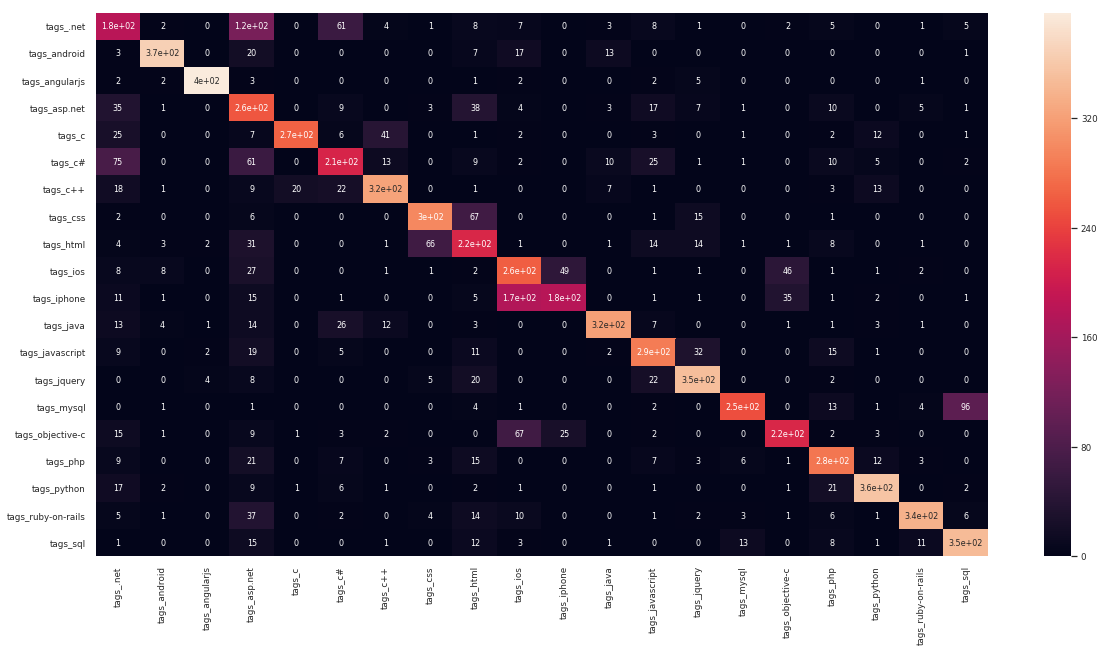

In [45]:
df_cm = pd.DataFrame(confusion_matrix(y_test,y_pred),index=classes_cols.values, columns=classes_cols.values)
plt.figure(figsize = (20,10))
sn.set(font_scale=0.8)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 8})# font size